In [1]:
# !pip install GPUtil

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
import numpy as np
import argparse
import torch
import sys
import importlib as ipb
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import GPUtil
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_mean(result_dict, stop_epoch, return_full=False):
    # Stop_epoch: determine when to stop computing the values.
    full_res = [np.array(i)[:stop_epoch] for i in result_dict.values()]
    if return_full:
        full_mean = np.round(100*np.mean(full_res, axis=0), 2)
        full_std = np.round(100*np.std(full_res, axis=0), 2)
        return [full_mean, full_std]  # For plot
    else:
        idx = [np.argmax(i[:, 1])
               for i in full_res]  # Collect idx at which valid is highest
        vals = [i[j] for i, j in zip(full_res, idx)]
        means = np.round(100*np.mean(vals, axis=0), decimals=2)
        stds = np.round(100*np.std(vals, axis=0), decimals=2)
        return [means, stds]  # For table

In [4]:
def non_empty_val(dict):
    keys = list(dict.keys())
    for key in keys:
        if len(dict[key]) > 0:
            return dict[key]


def plot_correct_split_best_SVI_or_SVI_warmstart(key_SVI_best, key_SVI_Adam_best, key_SGD, key_Adam, model_architect, lr0, full_epoch=True, return_early=False, frac=0.2):
    '''
        full_epoch: Decides if we plot the entire trajectory or just the initial segments
    '''
    result_dict = json.load(open(f'{key_SVI_best}.json'))
    results_over_runs_SVI = non_empty_val(result_dict)[0]
    result_dict = json.load(open(f'{key_SGD}.json'))
    results_over_runs_SGD = result_dict['SGD'][0]
    result_dict = json.load(open(f'{key_SVI_Adam_best}.json'))
    results_over_runs_SVI_Adam = non_empty_val(result_dict)[0]
    result_dict = json.load(open(f'{key_Adam}.json'))
    results_over_runs_Adam = result_dict['Adam'][0]
    tot_epoch = len(results_over_runs_SVI[f'lr={lr0[1:]}@Run1'])
    stop_epoch = tot_epoch if full_epoch else int(frac * tot_epoch)
    res_orig = [results_over_runs_SVI, results_over_runs_SGD,
                results_over_runs_SVI_Adam, results_over_runs_Adam]  # For plots later
    ################################################################
    return_full = not return_early
    results_SVI = get_mean(results_over_runs_SVI,
                           stop_epoch, return_full=return_full)
    results_SVI_Adam = get_mean(
        results_over_runs_SVI_Adam, stop_epoch, return_full=return_full)
    results_SGD = get_mean(results_over_runs_SGD,
                           stop_epoch, return_full=return_full)
    results_Adam = get_mean(results_over_runs_Adam,
                            stop_epoch, return_full=return_full)
    result_full = [results_SVI, results_SGD,
                   results_SVI_Adam, results_Adam]
    result_full = [results_SVI, results_SGD]
    if return_early:
        # Return results for table
        res_mean = np.concatenate([val[0] for val in result_full])
        res_std = np.concatenate([val[1] for val in result_full])
        return [res_mean, res_std]
    else:
        # Make plot
        mpl.rcParams['font.size'] = 20
        mpl.rcParams['axes.titlesize'] = 20
        mtd_dict = {0: 'SVI-SGD', 1: 'SGD',
                    2: 'SVI-Adam', 3: 'Adam'}
        mtd_dict = {0: 'SVI-SGD', 1: 'SGD'}
        fig, ax = plt.subplots(1, len(mtd_dict), figsize=(9*len(mtd_dict), 4), sharey=True, sharex=True)
        type_dict = {0: 'Train', 1: 'Test'}
        print(
            f'LR={lr0[1:]} up to {stop_epoch*num_log_steps} effective iterations')
        for i, result in enumerate(result_full):
            res_mean, res_std = result
            res_mean_final, res_std_final = get_mean(
                res_orig[i], stop_epoch, return_full=False)
            estart = 0
            end_inc = stop_epoch
            xtick = np.arange(estart, estart + end_inc) * num_log_steps
            for j in range(len(type_dict)):  # Train, Test
                ax[i].plot(xtick, res_mean[estart:estart
                           + end_inc, j], label=type_dict[j])
                ax[i].fill_between(xtick, res_mean[estart:estart + end_inc, j] - res_std[estart:estart + end_inc, j],
                                   res_mean[estart:estart + end_inc, j] + res_std[estart:estart + end_inc, j], alpha=0.3)
                if j == 0:
                    print(mtd_dict[i])
                ax[i].set_title(
                    f'{mtd_dict[i]} \n Train {res_mean_final[0]}' + r'$\pm$' + f'{res_std_final[0]}' + f', Test: {res_mean_final[1]}' + r'$\pm$' + f'{res_std_final[1]}', fontsize=22)
                ax[i].legend(loc='lower right', ncol=3)
                ax[i].grid(True)
        fig.tight_layout()
        full_e = '' if full_epoch else '_sub_epoch'
        fig.savefig(f'{dataname}SVI_only_SGD_Adam_vs_SGD_Adam{model_architect}{lr0}LR{full_e}.png',
                    dpi=100, bbox_inches='tight', pad_inches=0)
        plt.show()

### SVI-SGD vs. SGD on LeNet and both datasets

In [5]:
def get_result_dict(key_SVI_SGD, key_SGD):
    '''
        full_epoch: Decides if we plot the entire trajectory or just the initial segments
    '''
    result_dict = json.load(open(f'{key_SVI_SGD}.json'))
    results_over_runs_SVI = non_empty_val(result_dict)[0]
    result_dict = json.load(open(f'{key_SGD}.json'))
    results_over_runs_SGD = result_dict['SGD'][0]
    tot_epoch = len(results_over_runs_SVI[f'lr={lr0[1:]}@Run1'])
    res_orig = [results_over_runs_SVI, results_over_runs_SGD]  
    ################################################################
    results_SVI = get_mean(results_over_runs_SVI,
                           tot_epoch, return_full=True)
    results_SGD = get_mean(results_over_runs_SGD,
                           tot_epoch, return_full=True)
    results_SVI_highest = get_mean(results_over_runs_SVI,
                            tot_epoch, return_full=False)
    results_SGD_highest = get_mean(results_over_runs_SGD,
                            tot_epoch, return_full=False)
    return {'full':[results_SVI, results_SGD], 'highest':[results_SVI_highest, results_SGD_highest]}


# NOTE: I tried to "pause_SVI" after certain epochs, but it seems results not good
model_architect = '-4layers-512nodes'
lr0 = '-0.001'

dataname = 'MNIST_batched' # 'MNIST_batched' or 'CIFAR10_batched'

# # For this key_SVI, may or may not use warmstart, depending on if warm start is the best
# key_SVI = f'{dataname}SVI_warmstart-SGD{model_architect}{lr0}LR'
# key_SGD = f'{dataname}SGD{model_architect}{lr0}LR'
# MNIST_FCNet = get_result_dict(key_SVI, key_SGD)

key_SVI = f'{dataname}LeNet_SVI_warmstart-SGD{model_architect}{lr0}LR_loss_together_SVI_only'
key_SGD = f'{dataname}LeNet_SGD{model_architect}{lr0}LR_loss_together_SVI_only'
MNIST_LeNet = get_result_dict(key_SVI, key_SGD)

dataname = 'CIFAR10_batched'

# # For this key_SVI, may or may not use warmstart, depending on if warm start is the best
# key_SVI = f'{dataname}SVI_warmstart-SGD{model_architect}{lr0}LR'
# key_SGD = f'{dataname}SGD{model_architect}{lr0}LR'
# CIFAR10_FCNet = get_result_dict(key_SVI, key_SGD)

key_SVI = f'{dataname}VGG16_SVI_warmstart-SGD{model_architect}{lr0}LR_loss_together_SVI_only'
key_SGD = f'{dataname}VGG16_SGD{model_architect}{lr0}LR_loss_together_SVI_only'
CIFAR10_LeNet = get_result_dict(key_SVI, key_SGD)

In [25]:
def plot_on_ax(xtick, res_mean, res_std, ax, title, color):
    from matplotlib.ticker import MaxNLocator
    ax.plot(xtick, res_mean, label=title, color=color)
    ax.fill_between(xtick, res_mean - res_std, res_mean + res_std, alpha=0.3, color=color)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


def final_plot(result_full_ls, plot_train = False):
    # Make plot
    num_res = len(result_full_ls)
    if num_res == 2:
        title_ls = ['MNIST ', 'CIFAR10']
    else:
        title_ls = ['MNIST FCNet', 'MNIST LeNet', 'CIFAR10 FCNet', 'CIFAR10 LeNet']
    fig, ax = plt.subplots(1, num_res, figsize=(10*num_res, 4), sharex=True)
    for i in range(num_res):
        SVI_res, SGD_res = result_full_ls[i]['full']
        SVI_res_highest, SGD_res_highest = result_full_ls[i]['highest']
        xtick = range(1, len(SVI_res[0])+1)
        idx = 0 if plot_train else 1
        label = 'train' if plot_train else 'test'
        plot_on_ax(xtick, SVI_res[0][:,idx], SVI_res[1][:,idx], ax[i], 'SVI', 'orange')
        plot_on_ax(xtick, SGD_res[0][:,idx], SGD_res[1][:,idx], ax[i], 'SGD', 'black')
        SVI_final_mean, SVI_final_std = SVI_res_highest[0][idx], SVI_res_highest[1][idx]
        SGD_final_mean, SGD_final_std = SGD_res_highest[0][idx], SGD_res_highest[1][idx]
        title = title_ls[i] + f'\n SVI {label}: {SVI_final_mean}' + r'$\pm$' + f'{SVI_final_std}' + f', SGD {label}: {SGD_final_mean}' + r'$\pm$' + f'{SGD_final_std}'
        ax[i].set_title(title, fontsize = 22)
        ax[i].legend(loc='lower right', ncol=2, fontsize=22)
        ax[i].grid(True)
        ax[i].set_xlabel('Epoch', fontsize = 22)
        ax[i].set_ylabel('Test accuracy', fontsize = 22)
        # Increase ticklabel size
        ax[i].tick_params(axis='both', which='major', labelsize=18)
    fig.tight_layout(pad = 2)
    fig.savefig('SVI_only_SGD_vs_SGD_vision.png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

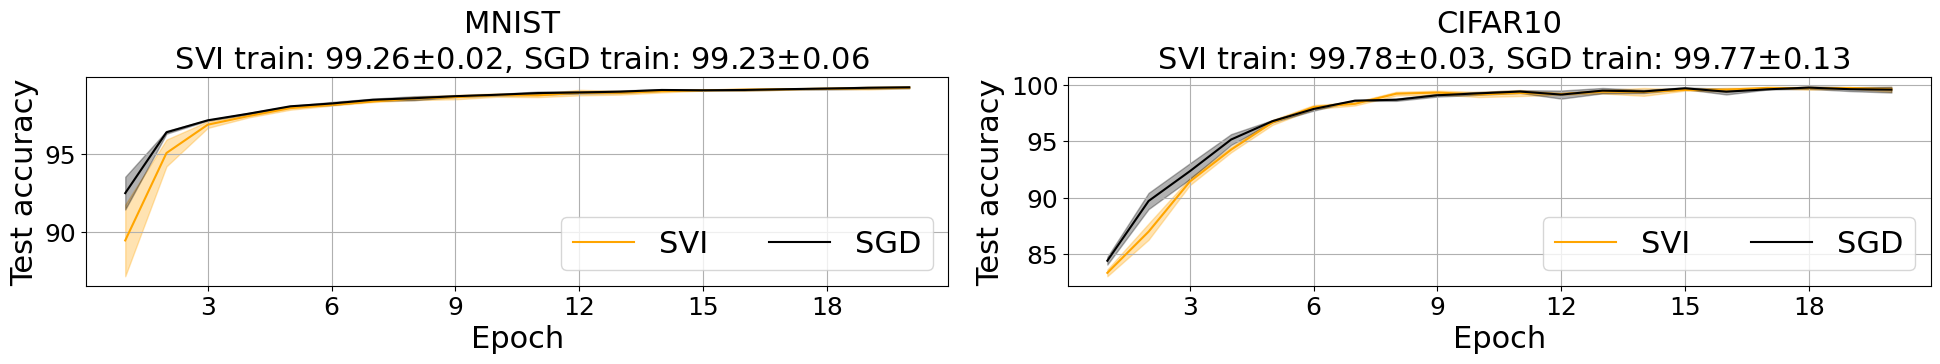

In [27]:
final_plot([MNIST_LeNet, CIFAR10_LeNet], plot_train = True)

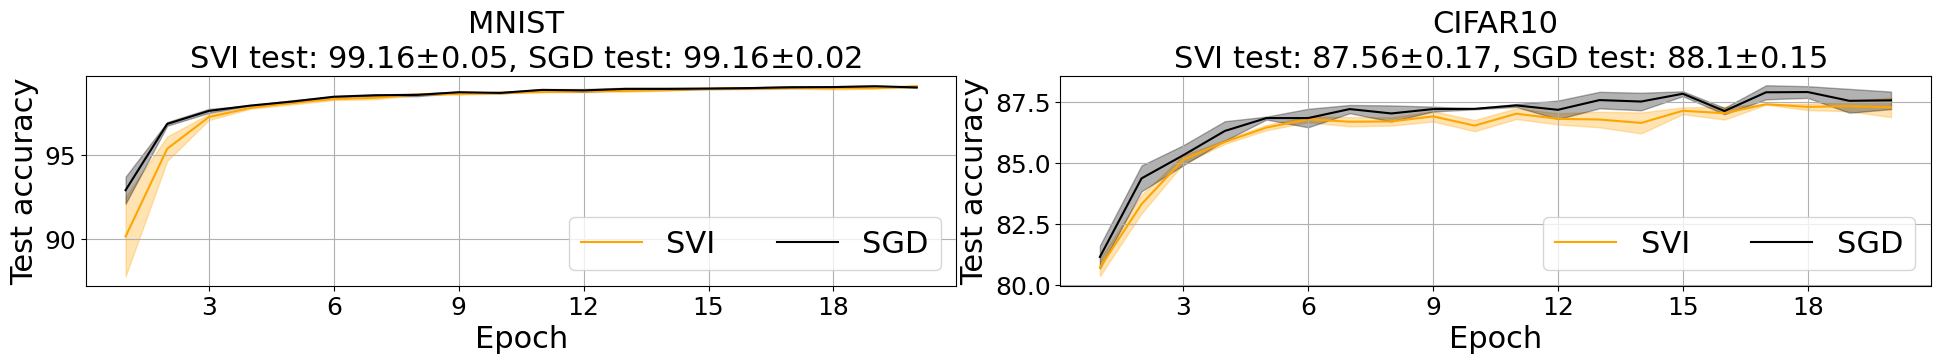

In [26]:
final_plot([MNIST_LeNet, CIFAR10_LeNet], plot_train = False)
# final_plot([MNIST_FCNet, MNIST_LeNet, CIFAR10_FCNet, CIFAR10_LeNet])

### MNIST with LeNet
* Best for SVI-SGD is with warm start
* Best for SVI-Adam is with warm start

#### Warm start, 10\%

In [7]:
mtds = ['SVI_warmstart-SGD', 'SGD','SVI_warmstart-Adam', 'Adam']
mtds = ['SVI_warmstart-SGD', 'SGD']
# mtds = ['SVI-SGD', 'SGD','SVI-Adam', 'Adam']

In [8]:
# NOTE: I tried to "pause_SVI" after certain epochs, but it seems results not good
model_architect = '-4layers-512nodes'
lrs = ['-0.001']
num_per_optimizer = 2*len(mtds)
full_result = np.zeros((len(lrs), 2 * num_per_optimizer))
# records results over initial training epochs.
full_result_sub = np.zeros((len(lrs), 2 * num_per_optimizer))
dataname = 'MNIST_batched' # 'MNIST_batched' or 'CIFAR10_batched'
frac = 0.1  # frac controls % of initial convergence
FC_only = False # True or False
if FC_only == False:
    dataname = dataname + 'LeNet_'
for i, lr0 in enumerate(lrs):
    key_SGD = f'{dataname}SGD{model_architect}{lr0}LR'
    key_Adam = f'{dataname}Adam{model_architect}{lr0}LR'
    key_SVI_warmstart = f'{dataname}SVI_warmstart-SGD{model_architect}{lr0}LR_loss_together_SVI_only_new_net'
    key_SVI_Adam_warmstart = f'{dataname}SVI_warmstart-Adam{model_architect}{lr0}LR_loss_together_SVI_only_new_net'
    # Use key_SVI(_warstart) or key_SVI_Adam(_warmstart)
    full_result[i] = np.concatenate(plot_correct_split_best_SVI_or_SVI_warmstart(
        key_SVI_warmstart, key_SVI_Adam_warmstart, key_SGD, key_Adam, model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split_best_SVI_or_SVI_warmstart(
        key_SVI_warmstart, key_SVI_Adam_warmstart, key_SGD, key_Adam, model_architect, lr0, full_epoch=False, return_early=True, frac=frac))
full_tmp = np.zeros((len(lrs), num_per_optimizer), dtype=object)
full_tmp_sub = np.zeros((len(lrs), num_per_optimizer), dtype=object)
full_result = np.round(full_result, 2)
full_result_sub = np.round(full_result_sub, 2)
for i in range(len(lrs)):
    for j in range(num_per_optimizer):
        full_tmp[i,
                 j] = f'{full_result[i, j]} ({full_result[i, num_per_optimizer+j]})'
        full_tmp_sub[i,
                     j] = f'{full_result_sub[i, j]} ({full_result_sub[i, num_per_optimizer+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
type = ['Train', 'Test']
tuples = list(zip(*[np.repeat(mtds, len(type)), np.tile(type, len(mtds))]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]

In [9]:
print('Result over all epochs')
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print(full_result.round(1).to_latex())
full_result

Result over all epochs
\begin{tabular}{lllll}
\toprule
{} & \multicolumn{2}{l}{SVI\_warmstart-SGD} & \multicolumn{2}{l}{SGD} \\
{} &             Train &          Test &         Train &          Test \\
\midrule
0.001 &      99.82 (0.07) &  99.22 (0.04) &  99.22 (0.06) &  99.16 (0.01) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_32/276930535.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.round(1).to_latex())


SVI_warmstart-SGD                         SGD              
                  Train          Test         Train          Test
0.001      99.82 (0.07)  99.22 (0.04)  99.22 (0.06)  99.16 (0.01)

In [10]:
print(f'Result over initial {100*frac}% epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub.round(1).to_latex())
full_result_sub

Result over initial 10.0% epochs
\begin{tabular}{lllll}
\toprule
{} & \multicolumn{2}{l}{SVI\_warmstart-SGD} & \multicolumn{2}{l}{SGD} \\
{} &             Train &          Test &         Train &          Test \\
\midrule
0.001 &      95.09 (0.88) &  95.36 (0.76) &  96.41 (0.09) &  96.89 (0.11) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_32/3638001340.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.round(1).to_latex())


SVI_warmstart-SGD                         SGD              
                  Train          Test         Train          Test
0.001      95.09 (0.88)  95.36 (0.76)  96.41 (0.09)  96.89 (0.11)

In [11]:
# # Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# # See Figure 1 of rebuttal
# model_architect='-4layers-512nodes'
# lrs=['-0.001']
# bsize = 128
# num_log_steps = 60000 // bsize if 'MNIST' in dataname else 50000 // bsize 
# for lr0 in lrs:
#     plot_correct_split_best_SVI_or_SVI_warmstart(key_SVI_warmstart, key_SVI_Adam_warmstart, key_SGD, key_Adam, model_architect, lr0, full_epoch=True)
#     plot_correct_split_best_SVI_or_SVI_warmstart(key_SVI_warmstart, key_SVI_Adam_warmstart, key_SGD, key_Adam, model_architect, lr0, full_epoch=False, frac = frac)

### CIFAR10 with LeNet
* Best for SVI-SGD is with warm start
* Best for SVI-Adam is with warm start

#### Warm start, 10\%

In [12]:
mtds = ['SVI_warmstart-SGD', 'SGD','SVI_warmstart-Adam', 'Adam']
mtds = ['SVI_warmstart-SGD', 'SGD']
# mtds = ['SVI-SGD', 'SGD','SVI-Adam', 'Adam']

In [19]:
# NOTE: I tried to "pause_SVI" after certain epochs, but it seems results not good
model_architect = '-4layers-512nodes'
lrs = ['-0.001']
num_per_optimizer = 2*len(mtds)
full_result = np.zeros((len(lrs), 2 * num_per_optimizer))
# records results over initial training epochs.
full_result_sub = np.zeros((len(lrs), 2 * num_per_optimizer))
dataname = 'CIFAR10_batched' # 'MNIST_batched' or 'CIFAR10_batched'
frac = 0.1  # frac controls % of initial convergence
FC_only = False # True or False
if FC_only == False:
    dataname = dataname + 'LeNet_'
for i, lr0 in enumerate(lrs):
    key_SGD = f'{dataname}SGD{model_architect}{lr0}LR'
    key_Adam = f'{dataname}Adam{model_architect}{lr0}LR'
    key_SVI_warmstart = f'{dataname}SVI_warmstart-SGD{model_architect}{lr0}LR_loss_together_SVI_only'
    key_SVI_Adam_warmstart = f'{dataname}SVI_warmstart-Adam{model_architect}{lr0}LR_loss_together_SVI_only'
    # Use key_SVI(_warstart) or key_SVI_Adam(_warmstart)
    full_result[i] = np.concatenate(plot_correct_split_best_SVI_or_SVI_warmstart(
        key_SVI_warmstart, key_SVI_Adam_warmstart, key_SGD, key_Adam, model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split_best_SVI_or_SVI_warmstart(
        key_SVI_warmstart, key_SVI_Adam_warmstart, key_SGD, key_Adam, model_architect, lr0, full_epoch=False, return_early=True, frac=frac))
full_tmp = np.zeros((len(lrs), num_per_optimizer), dtype=object)
full_tmp_sub = np.zeros((len(lrs), num_per_optimizer), dtype=object)
full_result = np.round(full_result, 2)
full_result_sub = np.round(full_result_sub, 2)
for i in range(len(lrs)):
    for j in range(num_per_optimizer):
        full_tmp[i,
                 j] = f'{full_result[i, j]} ({full_result[i, num_per_optimizer+j]})'
        full_tmp_sub[i,
                     j] = f'{full_result_sub[i, j]} ({full_result_sub[i, num_per_optimizer+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
type = ['Train', 'Test']
tuples = list(zip(*[np.repeat(mtds, len(type)), np.tile(type, len(mtds))]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]

In [20]:
print('Result over all epochs')
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print(full_result.round(1).to_latex())
full_result

Result over all epochs
\begin{tabular}{lllll}
\toprule
{} & \multicolumn{2}{l}{SVI\_warmstart-SGD} & \multicolumn{2}{l}{SGD} \\
{} &             Train &          Test &         Train &          Test \\
\midrule
0.001 &      74.29 (1.02) &  65.39 (0.29) &  66.49 (1.19) &  64.25 (1.64) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_32/276930535.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.round(1).to_latex())


SVI_warmstart-SGD                         SGD              
                  Train          Test         Train          Test
0.001      74.29 (1.02)  65.39 (0.29)  66.49 (1.19)  64.25 (1.64)

In [21]:
print(f'Result over initial {100*frac}% epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub.round(1).to_latex())
full_result_sub

Result over initial 10.0% epochs
\begin{tabular}{lllll}
\toprule
{} & \multicolumn{2}{l}{SVI\_warmstart-SGD} & \multicolumn{2}{l}{SGD} \\
{} &             Train &         Test &        Train &          Test \\
\midrule
0.001 &      30.55 (1.86) &  31.99 (2.2) &  37.69 (0.7) &  38.43 (0.69) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_32/3638001340.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.round(1).to_latex())


SVI_warmstart-SGD                       SGD              
                  Train         Test        Train          Test
0.001      30.55 (1.86)  31.99 (2.2)  37.69 (0.7)  38.43 (0.69)

In [ ]:
# # Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# # See Figure 1 of rebuttal
# model_architect='-4layers-512nodes'
# lrs=['-0.001']
# bsize = 128
# num_log_steps = 60000 // bsize if 'MNIST' in dataname else 50000 // bsize 
# for lr0 in lrs:
#     plot_correct_split_best_SVI_or_SVI_warmstart(key_SVI_warmstart, key_SVI_Adam_warmstart, key_SGD, key_Adam, model_architect, lr0, full_epoch=True)
#     plot_correct_split_best_SVI_or_SVI_warmstart(key_SVI_warmstart, key_SVI_Adam_warmstart, key_SGD, key_Adam, model_architect, lr0, full_epoch=False, frac = frac)